In [79]:
!pip install easyocr
!pip install twilio
!pip install opencv-python

In [ ]:
import tensorflow as tf
import os
import glob
import numpy as np

# Set TensorFlow compatibility settings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging
os.environ['TF_KERAS'] = '1'  # Use tf.keras instead of standalone Keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version for debugging
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.16.2


In [81]:
def load_model_safely(model_path):
    print(f"Attempting to load the model from {model_path}...")
    
    # First approach: Load with custom_objects and explicit options
    try:
        print("Approach 1: Loading model with custom_objects...")
        model = tf.keras.models.load_model(
            model_path, 
            compile=False,
            custom_objects=None
        )
        print("Model loaded successfully with Approach 1!")
        return model
    except Exception as e:
        print(f"Approach 1 failed: {str(e)}")
    
    # Second approach: Try loading with explicit TF 2.x settings
    try:
        print("Approach 2: Loading with explicit TensorFlow 2.x settings...")
        tf.keras.backend.clear_session()
        model = tf.keras.models.load_model(
            model_path,
            compile=False,
            options=tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost'
            )
        )
        print("Model loaded successfully with Approach 2!")
        return model
    except Exception as e:
        print(f"Approach 2 failed: {str(e)}")
    
    # Third approach: Create a new model and try to load weights
    try:
        print("Approach 3: Creating base model and loading weights...")
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(224, 224, 3),
            include_top=False,
            weights='imagenet'
        )
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
        model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
        
        try:
            model.load_weights(model_path)
            print("Weights loaded successfully!")
        except Exception as weight_err:
            print(f"Could not load weights: {weight_err}")
            print("Continuing with ImageNet pretrained weights only")
            
        return model
    except Exception as e:
        print(f"Approach 3 failed: {str(e)}")
    
    # Final fallback: Create a simple CNN model
    print("All loading approaches failed. Creating a simple fallback model...")
    print("WARNING: This model will not have your trained weights!")
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

In [82]:
def preprocess_frame(frame):
    # Resize to 224x224 (model input size)
    frame = cv2.resize(frame, (224, 224))
    # Convert to float32 and normalize to [0, 1]
    frame = frame.astype(np.float32) / 255.0
    # Normalize with mean and std used during training
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    frame = (frame - mean) / std
    # Expand dimensions to add batch axis (1, 224, 224, 3)
    frame = np.expand_dims(frame, axis=0)
    return frame
    

In [83]:
# Load the model
model_path = '/Users/saikalyansathish/Desktop/CAPSTONE PROJECT 2/capstone_model'
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found!")
    print("Looking for any .h5 files in current directory...")
    h5_files = glob.glob("*.h5")
    if h5_files:
        model_path = h5_files[0]
        print(f"Found alternative model file: {model_path}")
    else:
        print("No .h5 model files found. Will use a fallback model.")

model = load_model_safely(model_path)
class_names = ['helmet', 'half-helmet', 'no helmet']

Attempting to load the model from /Users/saikalyansathish/Desktop/CAPSTONE PROJECT 2/capstone_model...
Approach 1: Loading model with custom_objects...
Approach 1 failed: File format not supported: filepath=/Users/saikalyansathish/Desktop/CAPSTONE PROJECT 2/capstone_model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/Users/saikalyansathish/Desktop/CAPSTONE PROJECT 2/capstone_model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).
Approach 2: Loading with explicit TensorFlow 2.x settings...
Approach 2 failed: load_model() got an unexpected keyword argument 'options'
Approach 3: Creating base model and loading weights...
Could not load weights: File format not supported: filepath=/Users/saikalyansathish/Desk

In [84]:
import cv2
import numpy as np
from twilio.rest import Client
import os

In [85]:
import easyocr
from twilio.rest import Client
import cv2
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])  # For English
# Import visualization libraries
import matplotlib.pyplot as plt
import numpy as np

In [86]:
account_sid = 'ACa1dad329b9e0ecc2d2bdc4a0d8704510'
auth_token = 'c81acf5bff1e1af3577e6fcca2a1543a'
twilio_number = '+15677575158'
recipient_number = '+919916957771'  # e.g., authorities' number
client = Client(account_sid, auth_token)

In [87]:
def detect_helmet(image):
    # Preprocess the image for the model
    preprocessed = preprocess_frame(image)
    
    # Make prediction
    try:
        predictions = model.predict(preprocessed, verbose=0)
        predicted_class = np.argmax(predictions, axis=1)[0]
        confidence = predictions[0][predicted_class] * 100
        
        print(f"Prediction: {class_names[predicted_class]} with {confidence:.2f}% confidence")
        
        # Return 0 for proper helmet, 1 for half helmet or no helmet
        if predicted_class == 0:  # 'helmet' class
            return 0
        else:  # 'half-helmet' or 'no helmet' classes
            return 1
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return 1  # Default to violation in case of error

In [88]:
def process_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    
    # Display the original image
    plt_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(plt_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    try:
        # Run helmet detection
        label = detect_helmet(image)
        
        if label == 1:  # Violation detected
            # Extract number plate
            results = reader.readtext(image)
            
            if not results:
                print("No license plate detected")
                return
            
            # Create a copy for annotation
            annotated_image = image.copy()
            
            # Process OCR results
            license_plate = ""
            max_confidence = 0
            
            for (bbox, text, prob) in results:
                # Convert bbox points to integers for drawing
                points = np.array(bbox).astype(int)
                
                # Draw bounding box
                cv2.polylines(annotated_image, [points], True, (0, 255, 0), 2)
                
                # If this text has higher confidence, update license plate
                if prob > max_confidence:
                    license_plate = text
                    max_confidence = prob
            
            # Display annotated image
            plt_annotated = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 6))
            plt.imshow(plt_annotated)
            plt.title(f"Detected License Plate: {license_plate}")
            plt.axis('off')
            plt.show()
            
            # Send notification
            try:
                message = client.messages.create(
                    body=f'Helmet violation detected! License plate: {license_plate}',
                    from_=twilio_number,
                    to=recipient_number
                )
                print(f"Notification sent! Message SID: {message.sid}")
            except Exception as e:
                print(f"Failed to send notification: {str(e)}")
            
            return license_plate
        else:
            print("No violation detected - proper helmet worn")
            return None
            
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

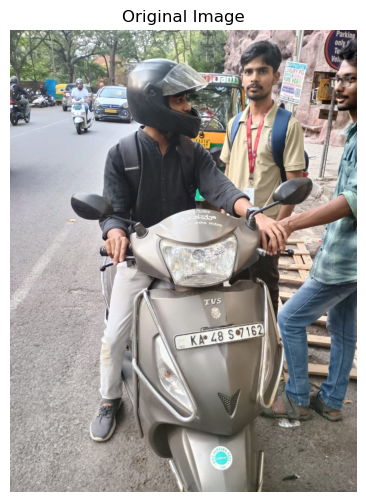

Prediction: no helmet with 56.59% confidence


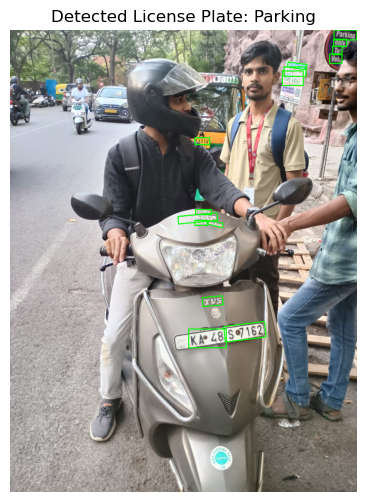

Notification sent! Message SID: SMe3e19e3fb31348a66933f5577ae26681


'Parking'

In [89]:
# Process the specific image
image_path = '/Users/saikalyansathish/Desktop/CAPSTONE PROJECT 2/WhatsApp Image 2025-05-14 at 17.39.13.jpeg'
process_image(image_path)

In [90]:
# Cell 6: Define function to send SMS via Twilio
def send_message(number_plate):
    message = client.messages.create(
        body=f"Violation detected. Number plate: {number_plate}",
        from_=twilio_number,
        to=recipient_number
    )
    print(f"Message sent: {message.sid}")

In [91]:
# Cell 7: Define function to process an image
def process_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    # Run helmet detection
    label = detect_helmet(image)
    if label == 1:
        # Violation detected, extract number plate
        results = reader.readtext(image)
        if results:
            number_plate = ' '.join([result[1] for result in results])
            print(f"Detected number plate: {number_plate}")
            send_message(number_plate)
        else:
            print("No text detected in the image.")
    else:
        print("No violation detected.")